# Student Admissions

**Predicting student admissions to graduate school at UCLA based on GRE Scores, GPA Scores, and class rank** 

**Supervised Learning. Classification**

Dataset from http://www.ats.ucla.edu/

Based on the [Predicting Student Admissions](https://github.com/udacity/aind2-dl) mini project of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [1]:
%matplotlib inline

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ds_boost
import keras

log = ds_boost.logger.init(level="DEBUG", save_log=False)

ds_boost.set_parent_execution_path()
ds_boost.info_system()
ds_boost.reproducible(seed=0)
sns.set()

23:32:34 - DEBUG 	 Path changed to /home/angel/DRIVE/0_repos/data-science-keras
23:32:34 - DEBUG 	 HARDWARE:
23:32:35 - DEBUG 	 CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
23:32:35 - DEBUG 	 RAM:	15 GB
23:32:35 - DEBUG 	 -- No GPU  --
23:32:35 - DEBUG 	 OS:	Linux-5.15.0-57-generic-x86_64-with-glibc2.35
23:32:35 - DEBUG 	 ENV:	/home/angel/miniconda3/envs/ds-keras
23:32:35 - DEBUG 	 PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
23:32:35 - DEBUG 	 tensorflow                   2.11.0
23:32:35 - DEBUG 	 pandas                        1.5.2
23:32:35 - DEBUG 	 numpy                        1.24.1
23:32:35 - DEBUG 	 EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
23:32:35 - DEBUG 	 EXECUTION DATE: Mon Jan 16 23:32:35 2023


## Load and prepare the data

In [2]:
data_path = "data/student_admissions.csv"
df = pd.read_csv(data_path)
df.head()

,admit,gre,gpa,rank
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [3]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [4]:
targets = ["admit"]
features = ["gre", "gpa", "rank"]

categorical = ["admit", "rank"]
numerical = ["gre", "gpa"]

# NaN values
df.fillna(df[numerical].median(), inplace=True)  # NaN from numerical feature replaced by median
df.dropna(axis="index", how="any", inplace=True)  # NaN from categorical feature: delete row

df_visualize = df  # copy for model visualization
df.shape

(399, 4)

### Visualize data

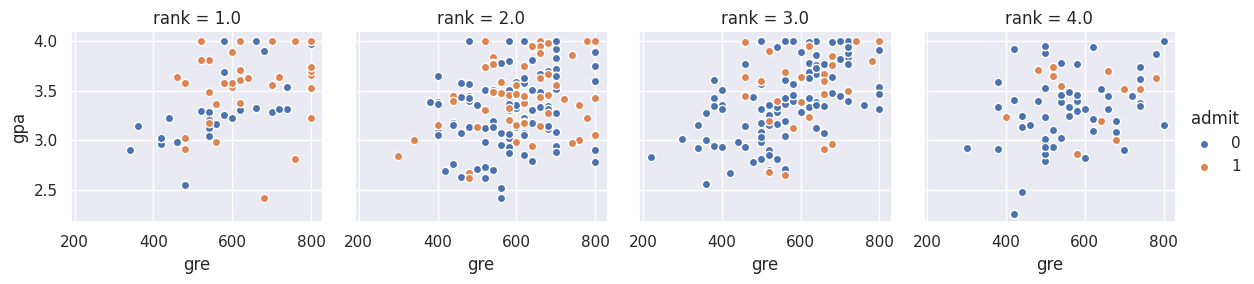

In [5]:
def plot_data(dataf, hue="admit"):
    """Custom plot for this project"""
    g = sns.FacetGrid(dataf, col="rank", hue=hue)
    g = g.map(plt.scatter, "gre", "gpa", edgecolor="w").add_legend()
    return g


plot_data(df)

### Create dummy variables

In [6]:
dummies = pd.get_dummies(df["rank"], prefix="rank", drop_first=False)
df = pd.concat([df, dummies], axis=1)
df = df.drop("rank", axis="columns")
df.head()

,admit,gre,gpa,rank_1.0,rank_2.0,rank_3.0,rank_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


### Scale numerical features

In [7]:
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in numerical:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean) / std
df.head()

,admit,gre,gpa,rank_1.0,rank_2.0,rank_3.0,rank_4.0
0,0,-1.800426,0.576244,0,0,1,0
1,1,0.625329,0.734075,0,0,1,0
2,1,1.838206,1.602149,1,0,0,0
3,1,0.452061,-0.528578,0,0,0,1
4,0,-0.587548,-1.212515,0,0,0,1


### Split the data into training and test sets

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train = train.drop(targets, axis=1).values, train[targets].values
x_test, y_test = test.drop(targets, axis=1).values, test[targets].values

### One-hot encoding the target

In [9]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Training set: \t x-shape = {} \t y-shape = {}".format(x_train.shape, y_train.shape))
print("Test set: \t x-shape = {} \t y-shape = {}".format(x_test.shape, y_test.shape))

Training set: 	 x-shape = (319, 6) 	 y-shape = (319, 2)
Test set: 	 x-shape = (80, 6) 	 y-shape = (80, 2)


## Deep Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                336       
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 98        
                                                                 
Total params: 434
Trainable params: 434
Non-trainable params: 0
_________________________________________________________________

Training ....
CPU times: user 4.12 s, sys: 219 ms, total: 4.34 s
Wall time: 3.76 s


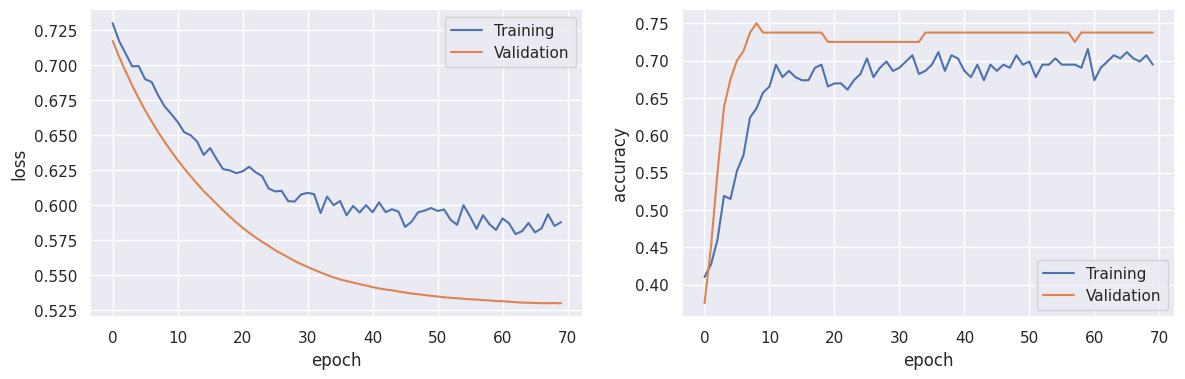

23:32:42 - DEBUG 	 Training loss:  	0.5878
23:32:42 - DEBUG 	 Validation loss: 	 0.5300
23:32:42 - DEBUG 	 Training accuracy: 	0.695
23:32:42 - DEBUG 	 Validation accuracy:	0.738

Model saved at models/student_admissions.h5


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

input_nodes = x_train.shape[1]*8
weights = keras.initializers.RandomNormal(stddev=0.1)

model = Sequential()
model.add(Dense(input_nodes, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax'))
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('\nTraining ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
%time history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, \
                          validation_split=0.25, callbacks=callbacks)
ds_boost.show_training(history)

model_path = os.path.join("models", "student_admissions.h5")
model.save(model_path)
print("\nModel saved at",model_path)

### Evaluate the model

In [11]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.2f}".format(score[1]))

Model loaded: models/student_admissions.h5

Test Accuracy: 0.75


### Visualize the model

13/13 [==============================] - 0s 1ms/step


Text(0.5, 0.98, 'Model')

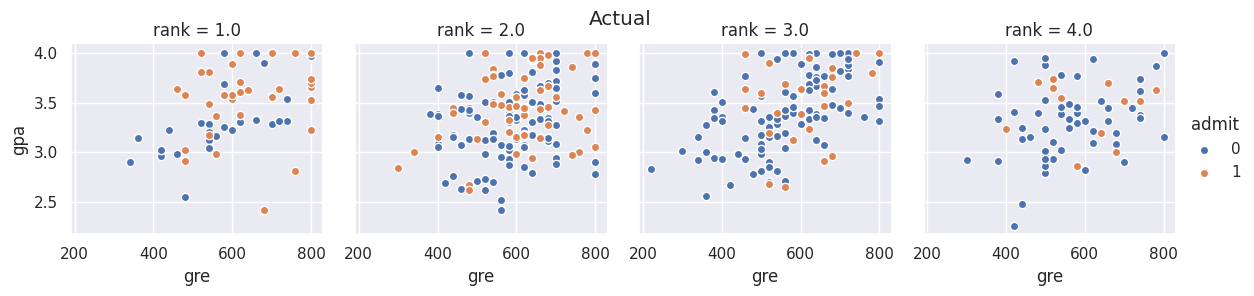

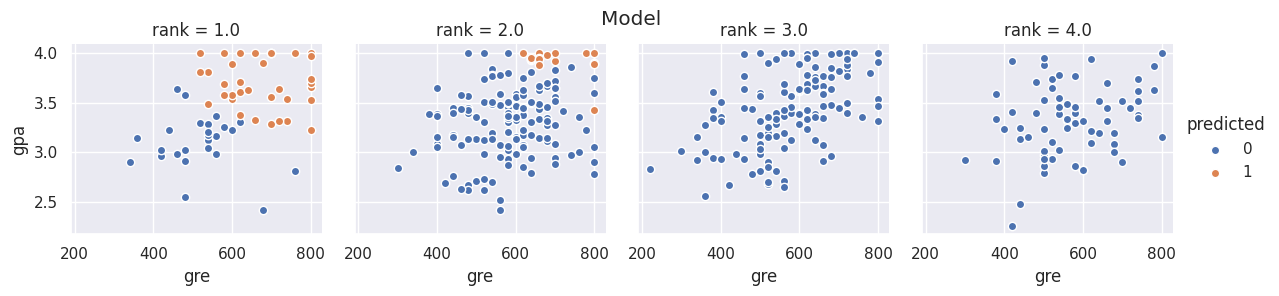

In [12]:
predictions = model.predict(df.drop(targets, axis=1).values)
predictions = np.argmax(predictions, axis=1)

df_visualize["predicted"] = predictions

plot_data(df_visualize).fig.suptitle("Actual")
plot_data(df_visualize, hue="predicted").fig.suptitle("Model")

A bit overfitting can be appreciated in `rank 2` sometimes. More information can be extracted when looking at the predicted probabilities instead of the binary accepted-rejected result shown here.

### Make predictions

In [13]:
def predict_admission(student):
    # student_data: {id: [gre, gpa, 'rank1, rank2, rank3, rank4]}

    print("Admission Probabilities: \n")

    for key, value in student.items():
        p_name = key
        single_data = value

        # normalize data
        for idx, f in enumerate(numerical):
            single_data[idx] = (single_data[idx] - scaled_features[f][0]) / scaled_features[f][1]

        # make prediction
        single_pred = model.predict(np.array([single_data]))
        print("{}: \t {:.0f}%\n".format(p_name, single_pred[0, 1] * 100))


df_visualize.describe()

,admit,gre,gpa,rank,predicted
count,399.000000,399.000000,399.000000,399.000000,399.000000
mean,0.315789,587.819549,3.390940,2.486216,0.130326
std,0.465413,115.428011,0.380152,0.945333,0.337084
min,0.000000,220.000000,2.260000,1.000000,0.000000
25%,0.000000,520.000000,3.130000,2.000000,0.000000
50%,0.000000,580.000000,3.395000,2.000000,0.000000
75%,1.000000,660.000000,3.670000,3.000000,0.000000
max,1.000000,800.000000,4.000000,4.000000,1.000000


In [14]:
# student_data: {id: [gre, gpa, 'rank1, rank2, rank3, rank4]}
new_students = {
    "High scores rank-1": [730, 3.83, 1, 0, 0, 0],
    "High scores rank-2": [730, 3.83, 0, 1, 0, 0],
    "High scores rank-3": [730, 3.83, 0, 0, 1, 0],
    "High scores rank-4": [730, 3.83, 0, 0, 0, 1],
    "Avg scores rank-1": [588, 3.4, 1, 0, 0, 0],
    "Avg scores rank-2": [588, 3.4, 0, 1, 0, 0],
    "Avg scores rank-3": [588, 3.4, 0, 0, 1, 0],
    "Avg scores rank-4": [588, 3.4, 0, 0, 0, 1],
}
predict_admission(new_students)

Admission Probabilities: 

1/1 [==============================] - 0s 19ms/step
High scores rank-1: 	 81%

1/1 [==============================] - 0s 20ms/step
High scores rank-2: 	 49%

1/1 [==============================] - 0s 20ms/step
High scores rank-3: 	 22%

1/1 [==============================] - 0s 28ms/step
High scores rank-4: 	 22%

1/1 [==============================] - 0s 25ms/step
Avg scores rank-1: 	 52%

1/1 [==============================] - 0s 20ms/step
Avg scores rank-2: 	 33%

1/1 [==============================] - 0s 22ms/step
Avg scores rank-3: 	 14%

1/1 [==============================] - 0s 27ms/step
Avg scores rank-4: 	 12%



The predictions confirm that `rank` is the most influential feature in determining the admission, which seems reasonable. The absolute grades of the students are more relevant for `rank-1` students (Q1).